## 1 - Veri yükleme ve sütunların tespiti

- **Taşınabilir yol**: `NEWS_CSV` ortam değişkeni → `data/news.csv` → `news.csv` sırasıyla aranır.
- Ayıraç ve encoding otomatik denenir (önce `;`, ardından `,`/`\t`, gerekirse `latin-1`).
- `category` içinde **genel / yaşam** filtrelenir (çalışmanın kapsamı dışında).
- Sütun isimleri normalize edilir, metin ve etiket kolonları **otomatik** bulunur.
- Çıktı: `global_vars = {df, text_col, label_col}` ve temel dağılımlar.


In [1]:
# HÜCRE 1 — SAĞLAM DOSYA OKUMA
import os
from pathlib import Path
import pandas as pd

# Aday dosya yolları (repo yapısı için önerilen: data/news.csv)
candidates = []
if os.getenv("NEWS_CSV"):
    candidates.append(Path(os.getenv("NEWS_CSV")))
candidates += [Path("data/news.csv"), Path("news.csv"), Path("../data/news.csv")]

file_path = None
for p in candidates:
    if p.exists():
        file_path = p
        break
if file_path is None:
    raise FileNotFoundError("news.csv bulunamadı. Lütfen dosyayı repo kökünde 'data/news.csv' olarak ekleyin "
                            "veya ortam değişkeni NEWS_CSV ile yol verin.")

# Ayıracı kokla (önce ; sonra , ve \t)
read_ok = False
for sep in [";", ",", "\t", None]:
    try:
        if sep is None:
            df = pd.read_csv(file_path, engine="python")
        else:
            df = pd.read_csv(file_path, sep=sep)
        read_ok = True
        break
    except Exception:
        continue
if not read_ok:
    # son çare: encoding fallback
    df = pd.read_csv(file_path, sep=";", encoding="latin-1")

print(f"Veri seti yüklendi: {file_path}\n")

# Gereksiz kategorileri filtrele
categories_to_remove = ['genel', 'yaşam']
if 'category' in df.columns:
    df = df[~df['category'].isin(categories_to_remove)].reset_index(drop=True)

print("--- Genel Bilgiler ---")
df.info()

print("\n--- İlk 5 Satır ---")
print(df.head())

# Sütun normalizasyonu
df.columns = df.columns.str.lower().str.strip()

# Olası metin/etiket kolonları
text_candidates  = ['text', 'content', 'body', 'haber_metni', 'metin']
label_candidates = ['label', 'category', 'etiket', 'kategori', 'class']

text_col  = next((c for c in text_candidates  if c in df.columns), None)
label_col = next((c for c in label_candidates if c in df.columns), None)
if not text_col or not label_col:
    print("\nMevcut sütunlar:", list(df.columns))
    raise ValueError("Metin/etiket sütunları bulunamadı.")

print(f"\nMetin sütunu: {text_col} | Etiket sütunu: {label_col}")

print("\n--- Eksik Değerler ---")
print(df[[text_col, label_col]].isnull().sum())

print("\n--- Kategori Dağılımı ---")
print(df[label_col].value_counts())

global_vars = {'df': df, 'text_col': text_col, 'label_col': label_col}
print("\nVeri incelemesi tamamlandı.")


Veri seti yüklendi: news.csv

--- Genel Bilgiler ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34675 entries, 0 to 34674
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   34675 non-null  object
 1   category  34675 non-null  object
 2   headline  34675 non-null  object
dtypes: object(3)
memory usage: 812.8+ KB

--- İlk 5 Satır ---
                                             content category  \
0  Dışişleri Bakanı Davutoğlu, Yunanistan ile Tür...    dünya   
1  İsrail Gazze Şeridi'nin kuzeyindeki bir tarlay...    dünya   
2  Lübnan'ın başkenti Beyrut'ta düzenlenen bombal...    dünya   
3  KKTC'de Sendikal Platform genel grev başlattı....    dünya   
4  Türkiye'den yola çıkan Başak Bulut, Seçil Öznu...    dünya   

                                            headline  
0                           'Ortak vizyonumuz var'\r  
1        İsrail'den Gazze Şeridi'ne hava saldırısı\r  
2      Cenaze için geniş güven

## 2 - Metin temizleme (TR)

- **Adımlar:** lower/casefold → URL/HTML temizliği → noktalama/sayı temizliği → çoklu boşluk → stopwords çıkarma → (varsa) **TurkishStemmer** ile kök bulma.
- Neden: TF-IDF’in **gürültüsüz** ve **tutarlı** kelime uzayına oturması.
- Çıktı: `df['clean_content']`, örnek giriş/çıkışlar ve `clean_content_col` değişkeni.


In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer

# NLTK stopwords hazır mı?
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK stopwords indiriliyor...")
    nltk.download('stopwords')

df        = global_vars['df']
text_col  = global_vars['text_col']
label_col = global_vars['label_col']

turkish_stopwords = stopwords.words('turkish')
stemmer = TurkishStemmer()

# ASCII dışı noktalama ve özel karakterleri de sil
EXTRA_PUNCT = "’‘“”–—…•·ªº°"
PUNCT_TABLE = str.maketrans('', '', string.punctuation + EXTRA_PUNCT)

def clean_text_tr(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Türkçe için daha güvenli küçültme
    text = text.casefold()
    # URL ve HTML temizliği
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    # Noktalama, sayı ve fazla boşluk
    text = text.translate(PUNCT_TABLE)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Kelimeleri ayır, stopwords'ü temizle ve kök bulma uygula
    words = []
    for w in text.split():
        if w not in turkish_stopwords:
            words.append(stemmer.stem(w))
            
    text = ' '.join(words)
    return text

df['clean_content'] = df[text_col].apply(clean_text_tr)
global_vars['clean_content_col'] = 'clean_content'

print("Temizleme tamamlandı. Örnekler:")
for i in range(min(5, len(df))):
    print(f"\nOrijinal: {str(df[text_col].iloc[i])[:100]}...")
    print(f"Temizlenmiş: {df['clean_content'].iloc[i][:100]}...")

Temizleme tamamlandı. Örnekler:

Orijinal: Dışişleri Bakanı Davutoğlu, Yunanistan ile Türkiye arasındaki farlılıkların ortak vizyon ile çözüleb...
Temizlenmiş: dışiş bakan davutok yunanistan türki ara farlılık ortak vizyon çözülebilecek söyl...

...jinal: İsrail Gazze Şeridi'nin kuzeyindeki bir tarlaya hava saldırısı düzenledi.
Temizlenmiş: i̇srail gazze şerit kuzey bir tarla hav saldırı düzen...

Orijinal: Lübnan'ın başkenti Beyrut'ta düzenlenen bombalı saldırıda öldürülen Lübnan İç Güvenlik Birimi İstihb...
Temizlenmiş: lübna başken beyrut düzenlenen bomba saldırı öldürülen lübnan i̇ç güvenlik bir i̇stihbarat başkan vi...

Orijinal: KKTC'de Sendikal Platform genel grev başlattı. Lefkoşa Belediyesi çalışanlarına destek vermek amacıy...
Temizlenmiş: kktcde sendikal platform genel grev başlat lefkoş belediye çalışan destek vermek amaç ülk genel grev...

Orijinal: Türkiye'den yola çıkan Başak Bulut, Seçil Öznur ve Alexios Menexiadis, bisikletle Asya ülkeleri Tayl...
Temizlenmiş: türkiye 

## 3 - EDA (temiz metin üzerinden)

- `word_count_clean` üretir; boş kayıtlar hariç tutulur.
- **Histogram** (%99 kırpma) ile genel uzunluk dağılımı.
- **Kutu grafiği** ile kategori bazında kelime sayısı karşılaştırması (medyana göre sıralı).
- Amaç: çok kısa/çok uzun haber kümeleri, kategoriye göre uzunluk farkları vb. öngörüler.


Bilgi: CLEAN metni boş olan 2840 satır görselleştirmeden çıkarıldı.
Kelime Sayısı (CLEAN) İstatistikleri:
count    31835.000000
mean        24.320905
std         25.782728
min          1.000000
25%         14.000000
50%         19.000000
75%         29.000000
max       1884.000000
Name: word_count_clean, dtype: float64

Kategori Bazında Ortalama Kelime Sayısı (CLEAN):
category
türkiye         34.498881
ekonomi         30.372423
sağlık          25.892922
güncel          24.669078
planet          24.494877
kültür-sanat    24.036187
spor            23.584552
teknoloji       23.096104
siyaset         22.545846
dünya           20.798937
magazin         18.337558
Name: word_count_clean, dtype: float64


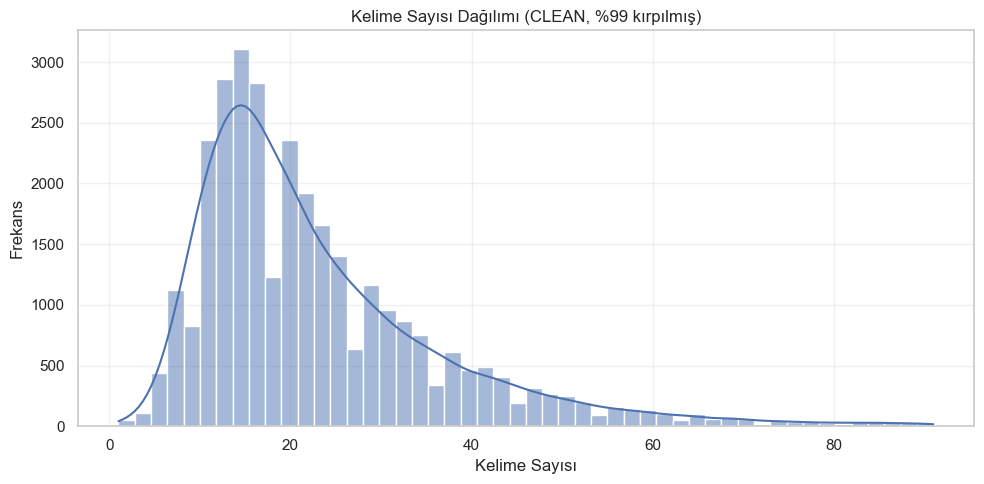

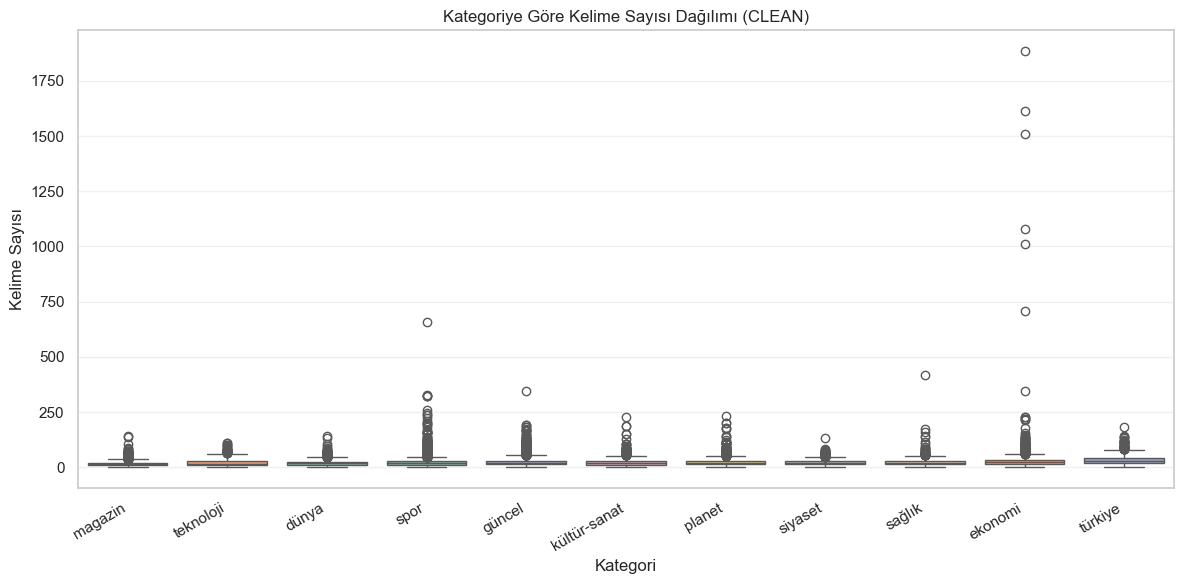

In [3]:
# Hücre 3 — EDA (CLEAN metin üzerinden)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Bağlam
df        = global_vars['df']
text_col  = global_vars['text_col']
label_col = global_vars['label_col']
clean_col = global_vars.get('clean_content_col', 'clean_content')

# Gerekli sütunlar
use_cols = [c for c in [text_col, label_col, clean_col] if c in df.columns]
eda_df = df[use_cols].copy()

# CLEAN kelime sayısı
eda_df['word_count_clean'] = eda_df[clean_col].astype(str).str.split().str.len()

# Boş CLEAN metinleri hariç tut (QC bilgisi yazdır)
clean_blank_mask = eda_df[clean_col].isna() | eda_df[clean_col].astype(str).str.strip().eq('')
n_blank = int(clean_blank_mask.sum())
if n_blank:
    print(f"Bilgi: CLEAN metni boş olan {n_blank} satır görselleştirmeden çıkarıldı.")
eda_df = eda_df.loc[~clean_blank_mask].copy()

print("Kelime Sayısı (CLEAN) İstatistikleri:")
print(eda_df['word_count_clean'].describe())

print("\nKategori Bazında Ortalama Kelime Sayısı (CLEAN):")
print(
    eda_df.groupby(label_col, dropna=False)['word_count_clean']
          .mean()
          .sort_values(ascending=False)
)

# Histogram: p99 kırpma (okunabilirlik)
p99 = np.nanpercentile(eda_df['word_count_clean'], 99)
plt.figure(figsize=(10,5))
sns.histplot(
    eda_df.loc[eda_df['word_count_clean'] <= p99, 'word_count_clean'],
    bins=50, kde=True
)
plt.title('Kelime Sayısı Dağılımı (CLEAN, %99 kırpılmış)')
plt.xlabel('Kelime Sayısı'); plt.ylabel('Frekans')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Kutu grafiği: kategori medyanına göre sıralı
order = (
    eda_df.groupby(label_col, dropna=False)['word_count_clean']
          .median()
          .sort_values()
          .index
)

plt.figure(figsize=(12,6))
ax = sns.boxplot(
    x=label_col, y='word_count_clean',
    data=eda_df, order=order,
    hue=label_col,           # palette kullanıldığı için hue ekliyoruz (FutureWarning yok)
    palette='Set2',
    dodge=False
)
leg = ax.get_legend()
if leg is not None:
    leg.remove()

plt.title('Kategoriye Göre Kelime Sayısı Dağılımı (CLEAN)')
plt.xlabel('Kategori'); plt.ylabel('Kelime Sayısı')
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


## 4- 70/15/15 split ve vektörleştirme

- Bölme: **%70 train**, %15 validation, %15 test (**stratified**).
- Vektörler: **Count (1–2 n-gram, 10k özellik)** ve **TF-IDF (1–2 n-gram, 10k)**.
- Not: Sonraki adımlarda SMOTE ile uyum için **TF-IDF** hattını kullanacağız.
- Çıktı: `X_train/_val/_test` (count ve tfidf), `y_train/_val/_test`, vektörleyiciler.


In [4]:
# HÜCRE 4 — 70/15/15 ve vektörleştirme
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

df               = global_vars['df']
label_col        = global_vars['label_col']

# Temizleme sonucu gelen kolon adı (Hücre 2'yi çalıştırdıktan sonra set edilir)
clean_content_col = global_vars.get('clean_content_col', 'clean_content')
if clean_content_col not in df.columns:
    raise RuntimeError("Önce Hücre 2'yi çalıştırarak 'clean_content' üretin.")

# Boş temiz metinleri at
df = df[df[clean_content_col].astype(str).str.strip() != ''].reset_index(drop=True)
global_vars['df'] = df

X = df[clean_content_col]
y = df[label_col]

# %70 train, %30 temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
# %30'u eşit böl → %15 val, %15 test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Eğitim: {len(X_train)} | Doğrulama: {len(X_val)} | Test: {len(X_test)}")

# Vektörleştiriciler
vectorizer_count = CountVectorizer(ngram_range=(1, 2), max_features=10000)
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_count = vectorizer_count.fit_transform(X_train)
X_val_count   = vectorizer_count.transform(X_val)
X_test_count  = vectorizer_count.transform(X_test)

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_val_tfidf   = vectorizer_tfidf.transform(X_val)
X_test_tfidf  = vectorizer_tfidf.transform(X_test)

print(f"BoW eğitim matrisi:  {X_train_count.shape}")
print(f"TF-IDF eğitim matrisi: {X_train_tfidf.shape}")

global_vars.update({
    'X_train_count': X_train_count, 'X_val_count': X_val_count, 'X_test_count': X_test_count,
    'X_train_tfidf': X_train_tfidf, 'X_val_tfidf': X_val_tfidf, 'X_test_tfidf': X_test_tfidf,
    'vectorizer_count': vectorizer_count, 'vectorizer_tfidf': vectorizer_tfidf,
    'y_train': y_train, 'y_val': y_val, 'y_test': y_test
})
print("\nVektörleştirme ve bölme tamam.")


Eğitim: 22284 | Doğrulama: 4775 | Test: 4776
BoW eğitim matrisi:  (22284, 10000)
TF-IDF eğitim matrisi: (22284, 10000)

Vektörleştirme ve bölme tamam.


## 4.5 - SMOTE ile min %5 dengeleme (yalnızca train)

- TF-IDF matrisi **SVD (300)** ile yoğun/ düşük boyutlu uzaya indirgenir (SMOTE stabilitesi).
- **Sabit-nokta çözümü** ile hedef eşik `t` bulunur: final train toplamı içinde **her sınıf ≥ %5** olacak.
- `k_neighbors` sınıfların min sayısına göre **güvenli** seçilir.
- **Sadece train** üzerinde uygulanır; **Val/Test dokunulmaz** (data leakage yok).
- Çıktı: `X_train_svd_smote`, `y_train_smote`, ayrıca `X_val_svd`, `X_test_svd`, `svd`.


In [8]:
# HÜCRE 4.5 — SMOTE ile final train'de her sınıfı en az %5'e çıkar (TF-IDF + SVD)
# !pip install imbalanced-learn  # gerekirse açın
from collections import Counter
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE

# Girdiler
X_train_tfidf = global_vars['X_train_tfidf']
X_val_tfidf   = global_vars['X_val_tfidf']
X_test_tfidf  = global_vars['X_test_tfidf']
y_train       = pd.Series(global_vars['y_train'])

# 1) Boyut indirgeme (SMOTE, yoğun ve daha düşük boyutta daha stabil çalışır)
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd   = svd.transform(X_val_tfidf)
X_test_svd  = svd.transform(X_test_tfidf)

# 2) Finalde en az %5 garantisi için hedef sayıları hesapla
p = 0.05
counts = y_train.value_counts().sort_values(ascending=False)
classes = counts.index.tolist()
total0  = counts.sum()

def compute_min_threshold(counts, p):
    """
    counts: pandas Series (class -> count), p: hedef oran (0.05)
    t için çöz: t >= p * sum(max(c_i, t))
    """
    t = math.ceil(p * counts.sum())  # başlangıç
    while True:
        majors = counts[counts >= t]
        M = len(counts) - len(majors)           # t'nin altında kalan sınıf sayısı
        S = int(majors.sum())                    # büyüklerin toplamı
        N = S + M * t
        needed = math.ceil(p * N)
        if needed <= t:
            return t
        t = needed

t = compute_min_threshold(counts, p)
target_counts = {cls: max(int(cnt), int(t)) for cls, cnt in counts.items()}

print("Orijinal dağılım (train):")
print((counts / counts.sum() * 100).round(2).astype(str) + "%")
print(f"\nHedef minimum adet (t): {t}  (sınıfı < {t} olanlar {t}'ye çıkarılacak)")

# 3) k_neighbors'ı güvenli seç (SMOTE: k <= min_class_count-1)
min_cls = counts.min()
k_safe = max(1, min(5, int(min_cls) - 1))
print(f"Güvenli k_neighbors: {k_safe}")

smote = SMOTE(random_state=42, sampling_strategy=target_counts, k_neighbors=k_safe)
X_train_svd_smote, y_train_smote = smote.fit_resample(X_train_svd, y_train)

# 4) Kontrol: final yüzde dağılımı (≥ %5 garanti)
final_counts = pd.Series(y_train_smote).value_counts().sort_index()
final_pct = (final_counts / final_counts.sum() * 100).round(2)

print("\nSMOTE sonrası dağılım (train):")
print(final_pct.astype(str) + "%")

# Sanity check
assert (final_counts / final_counts.sum() >= p - 1e-9).all(), "≥%5 koşulu sağlanamadı!"

# 5) Global değişkenleri güncelle
global_vars.update({
    'svd': svd,
    'X_train_svd_smote': X_train_svd_smote,
    'y_train_smote': y_train_smote,
    'X_val_svd': X_val_svd,
    'X_test_svd': X_test_svd
})

Orijinal dağılım (train):
category
spor            29.64%
güncel          18.23%
dünya           10.05%
ekonomi          9.75%
magazin          7.44%
planet           6.13%
siyaset          5.11%
türkiye          4.21%
kültür-sanat     3.56%
sağlık           3.46%
teknoloji        2.42%
Name: count, dtype: object

Hedef minimum adet (t): 1207  (sınıfı < 1207 olanlar 1207'ye çıkarılacak)
Güvenli k_neighbors: 5

SMOTE sonrası dağılım (train):
category
dünya            9.28%
ekonomi           9.0%
güncel          16.83%
kültür-sanat      5.0%
magazin          6.86%
planet           5.66%
sağlık            5.0%
siyaset           5.0%
spor            27.37%
teknoloji         5.0%
türkiye           5.0%
Name: count, dtype: object


## 5 - Dağılım karşılaştırması

- Train(SMOTE), Val ve Test için **sayı** ve **yüzde** tabloları.
- Yüzdelik **barplot** ile görsel karşılaştırma.
- Basit ayrışım ölçütü: **Jensen–Shannon divergence** (Train(SMOTE) vs Test) — 0'a yakınsa dağılımlar benzer.
- Beklenen: Train(SMOTE) ile Val/Test farklı olabilir; bu, azınlıkları öğretip performansı doğal dağılımda ölçmek içindir.



--- Sınıf Sayıları ---
              Train(SMOTE)   Val  Test
category                              
spor                  6606  1416  1416
güncel                4063   871   871
dünya                 2239   479   480
ekonomi               2173   465   466
magazin               1657   355   355
planet                1366   293   293
siyaset               1207   243   244
türkiye               1207   201   201
kültür-sanat          1207   170   170
sağlık                1207   166   165
teknoloji             1207   116   115

--- Sınıf Yüzdeleri ---
              Train% (SMOTE)   Val%  Test%
category                                  
spor                   27.37  29.65  29.65
güncel                 16.83  18.24  18.24
dünya                   9.28  10.03  10.05
ekonomi                 9.00   9.74   9.76
magazin                 6.86   7.43   7.43
planet                  5.66   6.14   6.13
siyaset                 5.00   5.09   5.11
türkiye                 5.00   4.21   4.21
kültür-sanat  

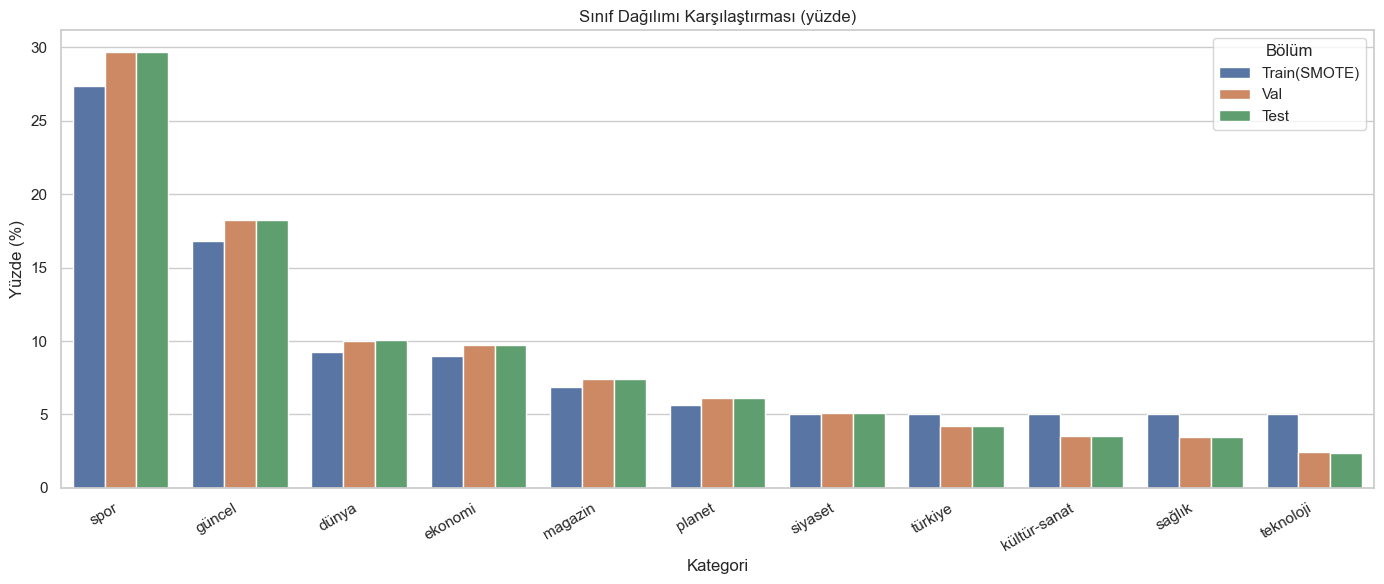


Jensen–Shannon (Train(SMOTE) vs Test): 0.0044  (0=aynı, ↑=fark artar)


In [10]:
# HÜCRE 5 — Dağılımlar (Train=SMOTE), Val ve Test = dokunulmamış
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

label_col = global_vars['label_col']
y_train_smote = pd.Series(global_vars['y_train_smote'])
y_val         = pd.Series(global_vars['y_val'])
y_test        = pd.Series(global_vars['y_test'])

# Tüm sınıfların birleşik ve sıralı listesi (toplam frekansa göre)
all_cats = pd.Index(y_train_smote).append(pd.Index(y_val)).append(pd.Index(y_test))
order = all_cats.value_counts().index.tolist()

def counts_and_pct(s: pd.Series, cats):
    c = s.value_counts().reindex(cats, fill_value=0)
    p = (c / c.sum() * 100).round(2)
    return c.astype(int), p

train_c, train_p = counts_and_pct(y_train_smote, order)
val_c,   val_p   = counts_and_pct(y_val,         order)
test_c,  test_p  = counts_and_pct(y_test,        order)

table_counts = pd.DataFrame({'Train(SMOTE)': train_c, 'Val': val_c, 'Test': test_c})
table_pct    = pd.DataFrame({'Train% (SMOTE)': train_p, 'Val%': val_p, 'Test%': test_p})
print("\n--- Sınıf Sayıları ---");  print(table_counts)
print("\n--- Sınıf Yüzdeleri ---"); print(table_pct)

# Barplot: yüzde karşılaştırması
plot_df = pd.concat([
    train_p.rename('value').to_frame().assign(split='Train(SMOTE)', category=lambda d: d.index),
    val_p.rename('value').to_frame().assign(split='Val',            category=lambda d: d.index),
    test_p.rename('value').to_frame().assign(split='Test',          category=lambda d: d.index),
], ignore_index=True)

plt.figure(figsize=(14,6))
ax = sns.barplot(data=plot_df, x='category', y='value', hue='split', order=order)
ax.set_title('Sınıf Dağılımı Karşılaştırması (yüzde)')
ax.set_xlabel('Kategori'); ax.set_ylabel('Yüzde (%)')
plt.xticks(rotation=30, ha='right'); plt.legend(title='Bölüm'); plt.tight_layout(); plt.show()

# Basit benzerlik metriği: Train(SMOTE) vs Test Jensen–Shannon
def js_divergence(p, q):
    p = np.asarray(p, dtype=float); p = p / p.sum()
    q = np.asarray(q, dtype=float); q = q / q.sum()
    m = (p + q) / 2.0
    def kl(a, b):
        mask = (a > 0) & (b > 0)
        return np.sum(a[mask] * np.log(a[mask] / b[mask]))
    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

jsd_train_test = js_divergence(train_c.values, test_c.values)
print(f"\nJensen–Shannon (Train(SMOTE) vs Test): {jsd_train_test:.4f}  (0=aynı, ↑=fark artar)")


## 6 - Model karşılaştırması (Val macro-F1)
- Karşılaştırılanlar:
  - **LinearSVC (class_weight='balanced')**
  - **LogisticRegression (OvR, class_weight='balanced')**
- Seçim ölçütü: **Validation macro-F1** (tüm sınıflara eş ağırlık).
- Çıktı: Karşılaştırma tablosu ve seçilen model (`best_model_obj`, `best_model_name`).


In [11]:
# HÜCRE 6 — SMOTE'lu eğitimle model kıyası
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

Xtr = global_vars['X_train_svd_smote']
ytr = pd.Series(global_vars['y_train_smote'])
Xva = global_vars['X_val_svd']
yva = pd.Series(global_vars['y_val'])

candidates = {
    'LinearSVC_bal': LinearSVC(random_state=42, class_weight='balanced'),
    'LogReg_bal'   : LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='ovr', solver='lbfgs')
}

rows = []
best_name, best_model, best_f1 = None, None, -1.0
for name, model in candidates.items():
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    acc  = accuracy_score(yva, pred)
    f1   = f1_score(yva, pred, average='macro')
    rows.append([name, acc, f1])
    if f1 > best_f1:
        best_f1, best_name, best_model = f1, name, model

cmp_df = pd.DataFrame(rows, columns=['Model','Acc(val)','F1_macro(val)']).sort_values('F1_macro(val)', ascending=False)
print("\n--- SMOTE'lu Karşılaştırma (Val) ---"); print(cmp_df)
print(f"\nSeçilen model: {best_name} | F1_macro(val)={best_f1:.4f}")

global_vars.update({'best_model_obj': best_model, 'best_model_name': best_name, 'val_cmp_df': cmp_df})


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



--- SMOTE'lu Karşılaştırma (Val) ---
           Model  Acc(val)  F1_macro(val)
0  LinearSVC_bal  0.697173       0.612561
1     LogReg_bal  0.681885       0.599293

Seçilen model: LinearSVC_bal | F1_macro(val)=0.6126


## 7 - Kaydetme (model + vectorizer + SVD + meta)

- Kaydedilen dosyalar:
  - `MODEL.joblib` (seçilen model)
  - `best_vectorizer.joblib` (TF-IDF)
  - `best_svd.joblib` (300 bileşen)
  - `best_meta.json` (tüm yol/isimler, sınıf listesi, kullanılan temsil)
- Neden meta? **Tahmin** tarafında pipeline'ı (TF-IDF → SVD → model) otomatik kurmak için.


In [12]:
# HÜCRE 7 — En iyi modeli ve öğeleri kaydet
from joblib import dump
import json, numpy as np

best_model = global_vars['best_model_obj']
best_name  = global_vars['best_model_name']
vectorizer = global_vars['vectorizer_tfidf']
svd        = global_vars['svd']

model_file      = f"{best_name}.joblib"
vectorizer_file = "best_vectorizer.joblib"
svd_file        = "best_svd.joblib"

dump(best_model, model_file)
dump(vectorizer, vectorizer_file)
dump(svd,        svd_file)

classes_ = getattr(best_model, "classes_", None)
meta = {
    "model_file": model_file,
    "vectorizer_file": vectorizer_file,
    "svd_file": svd_file,
    "model_name": best_name,
    "representation": "TFIDF->SVD (SMOTE train)",
    "used_smote": True,
    "classes_": classes_.tolist() if classes_ is not None else None
}
with open("best_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

global_vars['best_meta'] = meta
print("\nKaydedildi:")
print(f"- Model: {model_file}\n- Vektörleyici: {vectorizer_file}\n- SVD: {svd_file}\n- Meta: best_meta.json")



Kaydedildi:
- Model: LinearSVC_bal.joblib
- Vektörleyici: best_vectorizer.joblib
- SVD: best_svd.joblib
- Meta: best_meta.json


## 8 - Test değerlendirme (doğal dağılım)

- **Classification report** (precision/recall/F1, macro ort.)
- **Karışıklık matrisi** görselleştirmesi.
- Üst terimler: `coef_ @ svd.components_` ile **yaklaşık geri-yorumlama** (kategori başına en ayırt edici n-gram’lar).
  - Not: SVD nedeniyle bu yaklaşık bir projeksiyondur; yine de sezgisel yorum sağlar.



--- Test Sınıflandırma Raporu ---
              precision    recall  f1-score   support

       dünya       0.62      0.64      0.63       480
     ekonomi       0.72      0.79      0.75       466
      güncel       0.70      0.40      0.51       871
kültür-sanat       0.53      0.71      0.60       170
     magazin       0.74      0.73      0.74       355
      planet       0.51      0.43      0.46       293
      sağlık       0.60      0.87      0.71       165
     siyaset       0.43      0.63      0.51       244
        spor       0.95      0.95      0.95      1416
   teknoloji       0.40      0.73      0.52       115
     türkiye       0.24      0.26      0.25       201

    accuracy                           0.69      4776
   macro avg       0.58      0.65      0.60      4776
weighted avg       0.71      0.69      0.69      4776



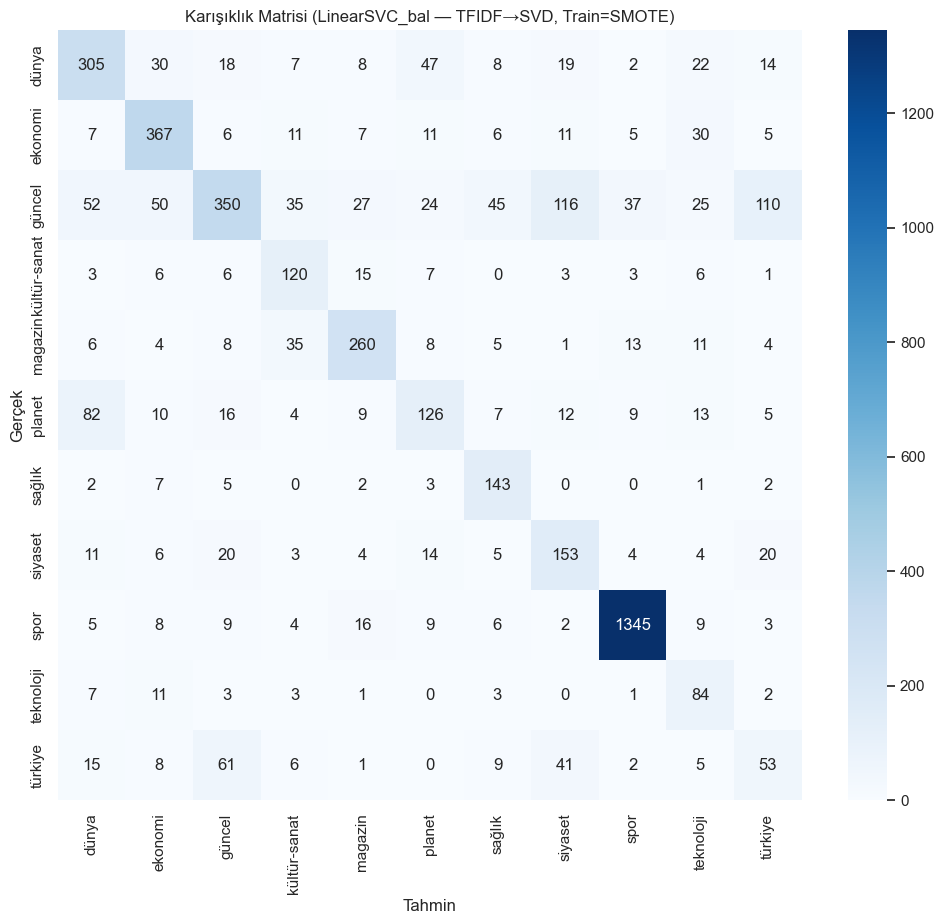


--- Sınıf başına yaklaşık üst 10 terim (SVD geri-yorumlama) ---

[dünya] -> rusya, çin, bildiril, srail, halk, suri, kent, lider, eyalet, ülke

[ekonomi] -> banka, şirket, milyar, fiyat, enerj, sektör, yatır, yüz, lira, mali

[güncel] -> ilçe, polis, yaş, sınav, çekiliş, sonuç, öğrenci, mart, lçesinde, emek

[kültür-sanat] -> film, kitap, sanat, tiyatro, müzik, ödül, kas, yazar, eser, kül

[magazin] -> dizi, oyunç, öncek, sevgi, ünl, eş, yarışma, şarkıç, sahne, program

[planet] -> abd, da, nin, de, nın, bir, lider, almanya, srail, ngiltere

[sağlık] -> hastalık, sağlık, uzman, kanser, hasta, fazl, dr, risk, çocuk, ilaç

[siyaset] -> chp, milletveki, başbakan, parti, erdoğan, süreç, det, bdp, bakan, söz

[spor] -> kulüp, taraftar, takım, transfer, futbolç, sezon, şampiyona, lig, deplasman, fenerbahçe

[teknoloji] -> oyun, teknoloji, dev, google, telefon, bilgisayar, akıl, internet, ilk, facebook

[türkiye] -> ilçe, olay, saat, neden, dava, ekip, asker, ankar, sıra, milletveki


In [13]:
# HÜCRE 8 — Test değerlendirme (SMOTE + SVD bilinçli)
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

with open('best_meta.json','r',encoding='utf-8') as f:
    meta = json.load(f)

model      = load(meta['model_file'])
vectorizer = load(meta['vectorizer_file'])
svd        = load(meta['svd_file']) if meta.get('svd_file') else None

y_test = pd.Series(global_vars['y_test'])

# Doğru test temsili
X_test = global_vars['X_test_svd']  # SVD'li test (Hücre 4.5'te kaydedildi)
y_pred = model.predict(X_test)
global_vars['y_pred'] = y_pred

print("\n--- Test Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred, zero_division=0))

labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f"Karışıklık Matrisi ({meta['model_name']} — TFIDF→SVD, Train=SMOTE)")
plt.xlabel('Tahmin'); plt.ylabel('Gerçek'); plt.show()

# --- Üst terimler (SVD üzerinden yaklaşık geri-yorumlama)
# LinearSVC/LogReg coef_ (n_classes x n_components), SVD components_ (n_components x n_features)
# Etkin ağırlık ~ W = coef_ @ components_
try:
    coef = getattr(model, "coef_", None)
    if coef is not None and svd is not None:
        feature_names = vectorizer.get_feature_names_out()
        W = coef @ svd.components_  # shape: (n_classes, n_features)
        classes = getattr(model, "classes_", labels)
        k = 10
        print(f"\n--- Sınıf başına yaklaşık üst {k} terim (SVD geri-yorumlama) ---")
        for i, cls in enumerate(classes):
            top_idx = np.argsort(W[i])[-k:][::-1]
            print(f"\n[{cls}] -> " + ", ".join(feature_names[top_idx]))
    else:
        print("\nNot: Bu model/kurulumda üst terimler çıkarılamadı.")
except Exception as e:
    print(f"\nÜst terimleri çıkarırken sorun: {e}")


## 9 - Hata analizi (en çok karıştırılan çift)

- Test seti üzerinde **en çok karıştırılan sınıf çifti** otomatik bulunur.
- Bu çift için birkaç örnek metin (temiz içerik) yazdırılır.
- Amaç: Sınır vakaları görmek; gerekirse ek özellikler, domain sözlükleri, bi-/tri-gram ayarları, `p` eşiği veya SMOTE varyantlarını gözden geçirmek.


In [14]:
# HÜCRE 9 — Yanlış sınıflandırma analizi
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix

df         = global_vars['df']
label_col  = global_vars['label_col']
clean_col  = global_vars['clean_content_col']
y_test     = pd.Series(global_vars['y_test'])
y_pred     = pd.Series(global_vars['y_pred'])

# Test setinin orijinal kayıtları + tahmin
df_test = df.loc[y_test.index].copy()
df_test['predicted'] = y_pred.values

# En çok karıştırılan çifti otomatik bul
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_off = cm.copy(); np.fill_diagonal(cm_off, 0)
i, j = np.unravel_index(cm_off.argmax(), cm_off.shape)
cat_true, cat_pred = labels[i], labels[j]; count_conf = cm_off[i, j]

print(f"\n--- Yanlış Sınıflandırma Analizi ---")
print(f"En çok karıştırılan çift: Gerçek='{cat_true}' -> Tahmin='{cat_pred}' (adet={count_conf})")

subset = df_test[(df_test[label_col] == cat_true) & (df_test['predicted'] == cat_pred)]
n_show = min(3, len(subset))
if n_show == 0:
    print("Bu karışım için örnek bulunamadı.")
else:
    print(f"\n[{cat_true} -> {cat_pred}] örneklerden {n_show} tanesi:")
    for _, row in subset.sample(n_show, random_state=42).iterrows():
        txt = str(row.get(clean_col, ""))[:400]
        print("\n--- Örnek ---")
        print(f"Gerçek: {row[label_col]} | Tahmin: {row['predicted']}")
        print(f"Metin: {txt}{'...' if len(txt)==400 else ''}")



--- Yanlış Sınıflandırma Analizi ---
En çok karıştırılan çift: Gerçek='güncel' -> Tahmin='siyaset' (adet=116)

[güncel -> siyaset] örneklerden 3 tanesi:

--- Örnek ---
Gerçek: güncel | Tahmin: siyaset
Metin: bdp genel başkan selahatti demirtaş yıl söyledik talep ettik bedel ödedik barış süreç fazl sahip çıkma gere süreç det

--- Örnek ---
Gerçek: güncel | Tahmin: siyaset
Metin: başbakan tayyip erdoğanın konvoy öncülük yapan motosiklet ekip kış koşul uygun özel yen kıyafet kullanma başl

--- Örnek ---
Gerçek: güncel | Tahmin: siyaset
Metin: aydinda ak partiden istifa e kiş dün bir kahve düzenlenen tören rozet takıp chpye geçt
